In [1]:
import math
import os

import librosa.display
import matplotlib.pyplot as plt
import pretty_midi as midi

In [2]:
# Input and output paths
PATH_IN = './files/midi/symphony.mid'
PATH_TARGET_FOLDER = './files/midi/'

# Separation options
SPLIT_EVERY_SEC = 10

In [3]:
# Read MIDi file and clean up
score = midi.PrettyMIDI(PATH_IN)
score.remove_invalid_notes()
print('Loaded "{}".'.format(PATH_IN))

Loaded "./files/midi/symphony.mid".


In [4]:
def find_elements_in_range(elements, start_time, end_time):
    """Filters elements which are within a time range."""
    
    filtered_elements = []
    
    for item in elements:
        if hasattr(item, 'start') and hasattr(item, 'end'):
            start = item.start
            end = item.end
        elif hasattr(item, 'time'):
            start = item.time
            end = item.time
            
        if not (end <= start_time or start >= end_time):
            if hasattr(item, 'start') and hasattr(item, 'end'):
                item.start = item.start - start_time
                item.end = item.end - start_time
            elif hasattr(item, 'time'):
                item.time = item.time - start_time
            
            filtered_elements.append(item)
            
    return filtered_elements


def split_score(score, split_every_sec=SPLIT_EVERY_SEC):
    """Break the MIDI file into smaller parts."""
    
    end_time = score.get_end_time()
    
    # Get instruments
    instruments = score.instruments
    
    # Get all time signature changes
    time_signature_changes = score.time_signature_changes
    
    # Get all key changes
    key_changes = score.key_signature_changes
    
    print('Score with {} instruments, '
          '{} signature changes, {} key changes and duration of {} sec.'.format(
              len(instruments),
              len(time_signature_changes),
              len(key_changes),
              end_time))
    
    last_time_signature_change = time_signature_changes[0]
    last_key_change = key_changes[0]
    
    splits = []
    
    # Split score into smaller time spans
    for split_index, split_start_time in enumerate(range(0,
                                                         math.ceil(end_time),
                                                         split_every_sec)):
        split_end_time = min(split_start_time + split_every_sec, end_time)
        
        split_instruments = []
        split_notes_counter = 0

        print('Generate split #{} from {} sec - {} sec.'.format(
            split_index + 1, split_start_time, split_end_time))
        
        for instrument in instruments:
            # Find notes for this instrument in this range
            split_notes = find_elements_in_range(instrument.notes,
                                                 split_start_time,
                                                 split_end_time)
            
            split_notes_counter += len(split_notes)
            
            # Create new instrument
            split_instrument = midi.Instrument(program=instrument.program,
                                               name=instrument.name)
            
            split_instrument.notes = split_notes
            split_instruments.append(split_instrument)
            
        # Find key and time signature changes
        split_time_signature_changes = find_elements_in_range(time_signature_changes,
                                                              split_start_time,
                                                              split_end_time)

        if len(split_time_signature_changes) > 0:
            last_time_signature_change = split_time_signature_changes[-1]
        else:
            split_time_signature_changes = [last_time_signature_change]

        split_key_signature_changes = find_elements_in_range(key_changes,
                                                             split_start_time,
                                                             split_end_time)

        if len(split_key_signature_changes) > 0:
            last_key_change = split_key_signature_changes[-1]
        else:
            split_key_signature_changes = [last_key_change]
            
        print('Found {} notes, added {} key changes and {} time signature changes.'.format(
            split_notes_counter,
            len(split_key_signature_changes),
            len(split_time_signature_changes)))
        
        splits.append({'instruments': split_instruments,
                       'time_signature_changes': split_time_signature_changes,
                       'key_signature_changes': split_key_signature_changes})
        
    return splits

In [5]:
# Split score!
splits = split_score(score)

Score with 12 instruments, 1 signature changes, 1 key changes and duration of 41.6208375 sec.
Generate split #1 from 0 sec - 10 sec.
Found 118 notes, added 1 key changes and 1 time signature changes.
Generate split #2 from 10 sec - 20 sec.
Found 204 notes, added 1 key changes and 1 time signature changes.
Generate split #3 from 20 sec - 30 sec.
Found 219 notes, added 1 key changes and 1 time signature changes.
Generate split #4 from 30 sec - 40 sec.
Found 244 notes, added 1 key changes and 1 time signature changes.
Generate split #5 from 40 sec - 41.6208375 sec.
Found 14 notes, added 1 key changes and 1 time signature changes.


In [6]:
def generate_piano_roll(score, title, path=None, start_pitch=0, end_pitch=127, fs=100):
    """Save a piano roll image."""
    
    fig = plt.figure()
    plt.figure(figsize=(12, 8))
    plt.title(title)
    
    librosa.display.specshow(score.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=midi.note_number_to_hz(start_pitch))
    
    if path is not None:
        plt.savefig(path)
        
    plt.close(fig)


def generate_midi_files(base_name, target_folder, splits):
    """Saves multiple splitted MIDI files and its piano roll plots in a folder."""
    
    for split_index, split in enumerate(splits):
        split_score = midi.PrettyMIDI()
        split_score.time_signature_changes = split['time_signature_changes']
        split_score.key_signature_changes = split['key_signature_changes']
        split_score.instruments = split['instruments']
        
        # Save MIDI file and piano roll plot
        split_file_name = '{}-split-{}.mid'.format(base_name, split_index + 1)
        split_file_path = os.path.join(target_folder, split_file_name)
        
        plot_file_name = '{}-split-{}.png'.format(base_name, split_index + 1)
        plot_file_path = os.path.join(target_folder, plot_file_name)
        
        generate_piano_roll(split_score, split_file_name, plot_file_path)
        
        split_score.write(split_file_path)
        
        print('Saved MIDI file and piano roll plot at "{}".'.format(
            split_file_path))

Saved MIDI file and piano roll plot at "./files/midi/symphony-split-1.mid".
Saved MIDI file and piano roll plot at "./files/midi/symphony-split-2.mid".
Saved MIDI file and piano roll plot at "./files/midi/symphony-split-3.mid".
Saved MIDI file and piano roll plot at "./files/midi/symphony-split-4.mid".
Saved MIDI file and piano roll plot at "./files/midi/symphony-split-5.mid".
Done!


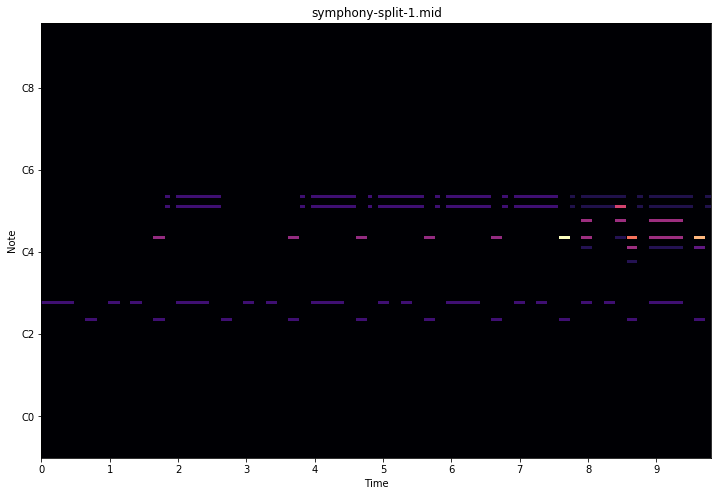

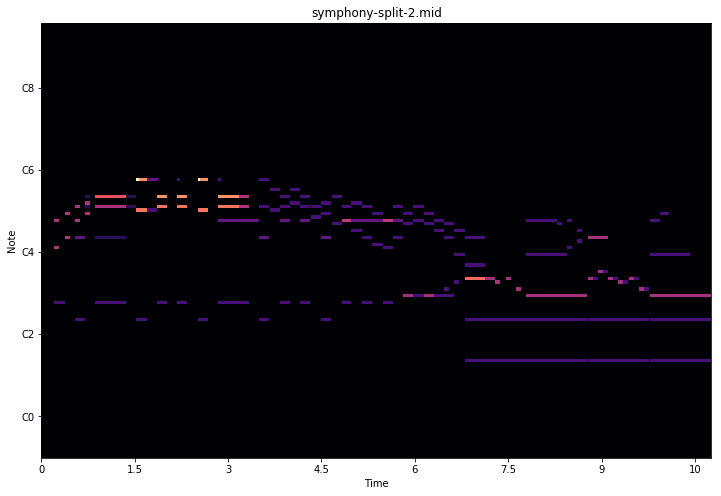

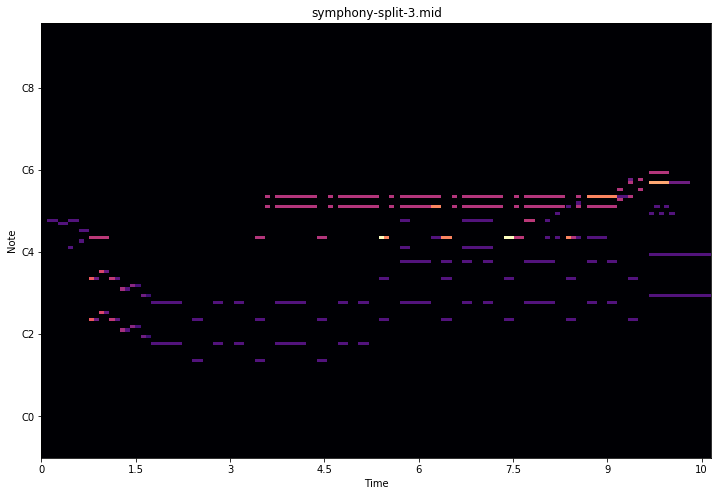

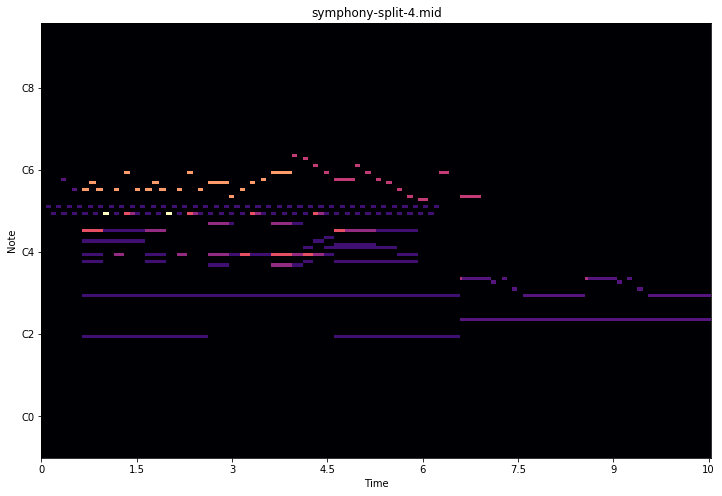

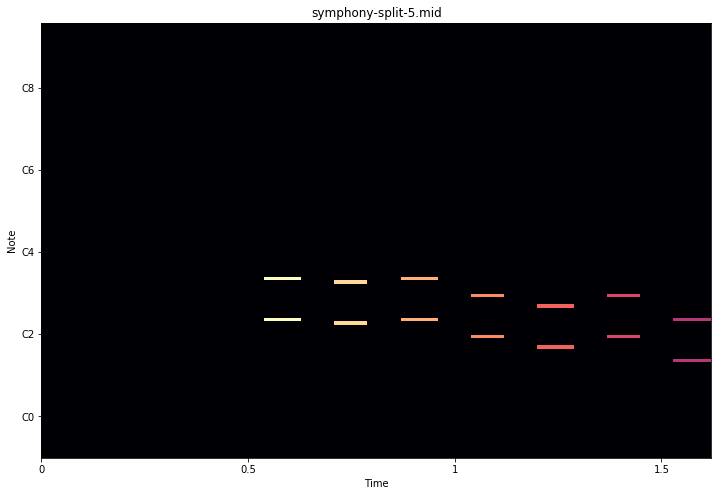

In [7]:
# Generate MIDI files from splits
base_name = os.path.splitext(os.path.basename(PATH_IN))[0]
generate_midi_files(base_name, PATH_TARGET_FOLDER, splits)

print('Done!')